In [1]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt
from ipywidgets import Output, VBox, Label
from matplotlib.widgets import Cursor

import pandas as pd
import cv2
import os

In [2]:
%matplotlib widget

In [3]:
video_path = "C:/Users/CLOCKWORK/Desktop/MMU Files/Trimester 11 (FYP)/Code/dataset/20240102 dataset 4/20240102001205.ts"

In [4]:
video = cv2.VideoCapture(video_path)

frames = []
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
sample_rate = max(frame_count // 50, 1)  # Sample up to 50 frames

frame_idx = 0
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
        
    if frame_idx % sample_rate == 0:
        frames.append(frame)
    frame_idx += 1
    
    if len(frames) >= 50:  # Stop collecting after 50 frames
        break


video.release()

# Compute the median frame
if frames:
    median_frame = np.median(np.array(frames), axis=0).astype(dtype=np.uint8)
else:
    print(f"No frames extracted for video")

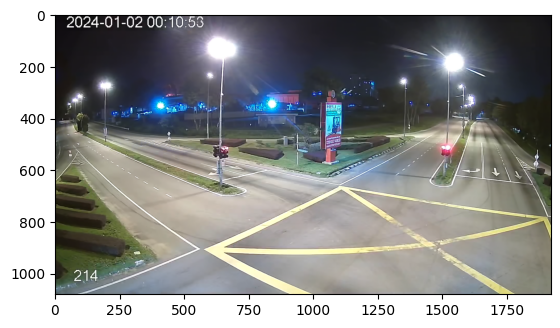

In [5]:
%matplotlib inline
median_rgb = cv2.cvtColor(median_frame, cv2.COLOR_BGR2RGB)
plt.imshow(median_rgb)
plt.show()

Output()

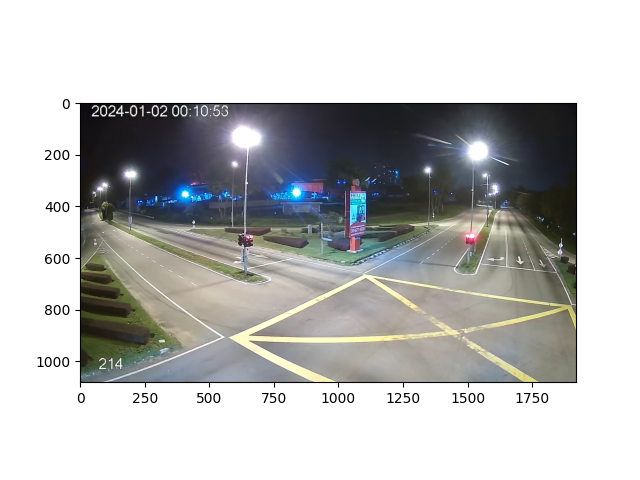

In [6]:
%matplotlib widget
clicked_points = []
parallel_pts = None  # This will store the final array
out = Output()

fig, ax = plt.subplots()
ax.imshow(median_rgb, cmap='gray')
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

display(out)

def onclick(event):
    global parallel_pts

    if event.inaxes != ax or len(clicked_points) >= 8:
        return

    # Record point
    x, y = event.xdata, event.ydata
    clicked_points.append((x, y))

    # Mark on the image
    ax.plot(x, y, 'ro')
    fig.canvas.draw()

    # When 8 points are selected, create parallel_pts and disconnect
    if len(clicked_points) == 8:
        parallel_pts = np.float32(clicked_points)
        print("Selected points:\n", parallel_pts)
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

Output()

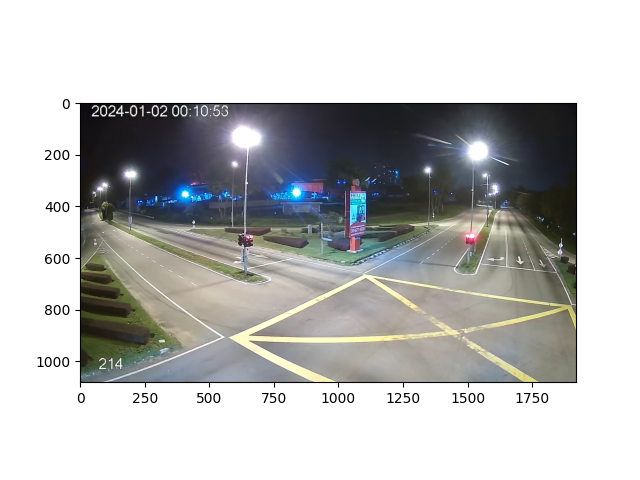

In [7]:
%matplotlib widget
clicked_points = []
ortho_pts = None  # This will store the final array
out = Output()

fig, ax = plt.subplots()
ax.imshow(median_rgb, cmap='gray')
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

display(out)

def onclick(event):
    global ortho_pts

    if event.inaxes != ax or len(clicked_points) >= 8:
        return

    # Record point
    x, y = event.xdata, event.ydata
    clicked_points.append((x, y))

    # Mark on the image
    ax.plot(x, y, 'ro')
    fig.canvas.draw()

    # When 8 points are selected, create ortho_pts and disconnect
    if len(clicked_points) == 8:
        ortho_pts = np.float32(clicked_points)
        print("Selected points:\n", ortho_pts)
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

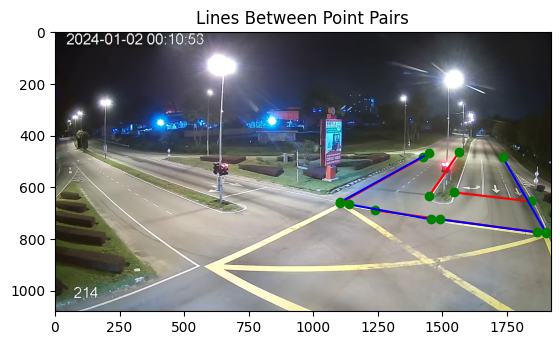

In [9]:
%matplotlib inline
# Plot image and lines
fig, ax = plt.subplots()
ax.imshow(median_rgb)

# Draw lines between point pairs
for i in range(0, len(parallel_pts), 2):
    pt1 = parallel_pts[i]
    pt2 = parallel_pts[i + 1]
    ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-')  # Red line
    ax.plot(pt1[0], pt1[1], 'go')  # Green point
    ax.plot(pt2[0], pt2[1], 'go')

for i in range(0, len(ortho_pts), 2):
    pt1 = ortho_pts[i]
    pt2 = ortho_pts[i + 1]
    ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'b-')  # Blue line
    ax.plot(pt1[0], pt1[1], 'go')  # Green point
    ax.plot(pt2[0], pt2[1], 'go')

plt.title('Lines Between Point Pairs')
plt.show()

In [10]:
def affine_rectify_points(points, parallel_lines_points):

    assert parallel_lines_points.shape == (8, 2)
    assert points.shape[1] == 2

    def get_line(p1, p2):
        return np.cross(np.append(p1, 1), np.append(p2, 1))

    # Get vanishing points from parallel lines
    line_pairs = [get_line(parallel_lines_points[i], parallel_lines_points[i+1]) for i in range(0, 8, 2)]
    vanishing_points = [np.cross(line_pairs[i], line_pairs[i+1]) for i in range(0, len(line_pairs), 2)]

    # Compute line at infinity
    l_inf = np.cross(vanishing_points[0], vanishing_points[1])
    l_inf /= l_inf[2]

    # Construct affine rectification homography
    H_affine = np.eye(3)
    H_affine[2] = l_inf

    # Apply the homography to the points
    points_h = np.hstack([points, np.ones((points.shape[0], 1))])
    rectified_h = (H_affine @ points_h.T).T
    rectified_points = rectified_h[:, :2] / rectified_h[:, 2:]

    return rectified_points

In [11]:
def metric_rectify_points(points_to_transform, orthogonal_points):

    assert orthogonal_points.shape == (8, 2), "Orthogonal points must be an array of shape (8, 2)."

    def get_line(p1, p2):
        return np.cross(np.append(p1, 1), np.append(p2, 1))

    lines = [get_line(orthogonal_points[i], orthogonal_points[i+1]) for i in range(0, 8, 2)]
    lines = [l / np.linalg.norm(l[:2]) for l in lines]  # Normalize to ignore direction

    equations = []
    for i in range(0, len(lines), 2):
        l1 = lines[i][:2]
        l2 = lines[i+1][:2]
        equation = [l1[0]*l2[0], l1[0]*l2[1] + l1[1]*l2[0], l1[1]*l2[1]]
        equations.append(equation)

    A = np.array(equations)
    _, _, Vt = np.linalg.svd(A)
    s = Vt[-1]

    S = np.array([[s[0], s[1]], [s[1], s[2]]])

    try:
        K_inv_T = np.linalg.cholesky(S).T
    except np.linalg.LinAlgError:
        U, D, Vt = np.linalg.svd(S)
        sqrt_D = np.diag(np.sqrt(D))
        K_inv_T = U @ sqrt_D @ Vt

    H_metric = np.eye(3)
    H_metric[:2, :2] = np.linalg.inv(K_inv_T)

    # Apply the homography to the input points
    num_pts = points_to_transform.shape[0]
    pts_homog = np.hstack([points_to_transform, np.ones((num_pts, 1))])
    pts_transformed_h = (H_metric @ pts_homog.T).T
    pts_transformed = pts_transformed_h[:, :2] / pts_transformed_h[:, 2, np.newaxis]

    return pts_transformed

In [12]:
affined_ortho_points = affine_rectify_points(ortho_pts,parallel_pts)

Output()

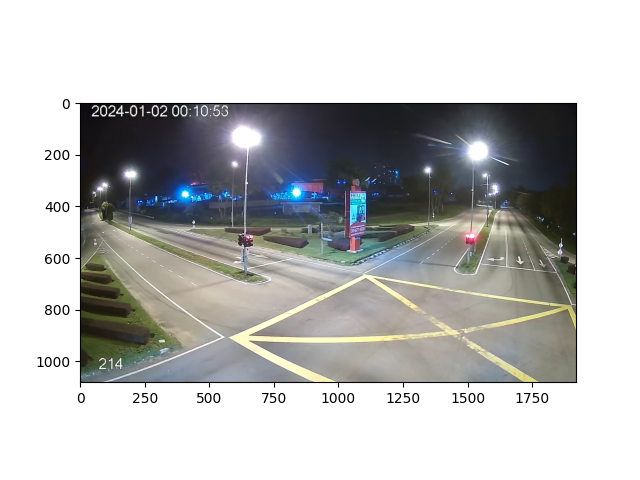

In [13]:
%matplotlib widget

clicked_points = []
known_points = None  # This will store the final array
out = Output()

fig, ax = plt.subplots()
ax.imshow(median_rgb, cmap='gray')
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

display(out)

def onclick(event):
    global known_points

    if event.inaxes != ax or len(clicked_points) >= 2:
        return

    # Record point
    x, y = event.xdata, event.ydata
    clicked_points.append((x, y))

    # Mark on the image
    ax.plot(x, y, 'ro')
    fig.canvas.draw()

    # When 2 points are selected, create known_points and disconnect
    if len(clicked_points) == 2:
        known_points = np.float32(clicked_points)
        print("Selected points:\n", known_points)
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [14]:
known_unit = 3.5

In [15]:
affine_distance_known = affine_rectify_points(known_points,parallel_pts)
ortho_distance_known = metric_rectify_points(affine_distance_known,affined_ortho_points)

scaler_unit = known_unit / np.linalg.norm(ortho_distance_known[0] - ortho_distance_known[1])

print(scaler_unit)

0.010236708005857678


Output()

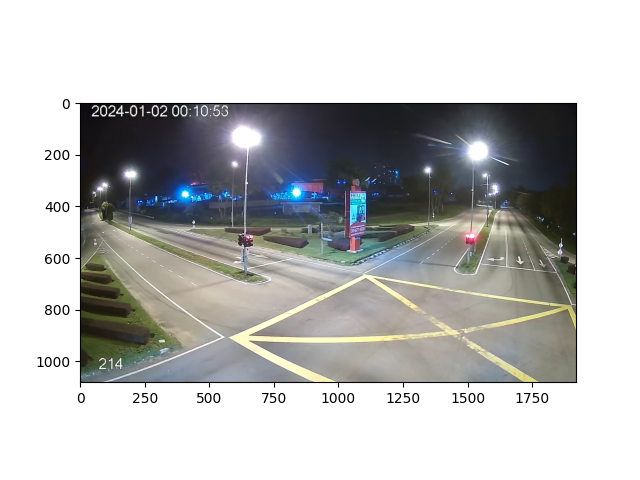

In [18]:
%matplotlib widget

clicked_points = []
unknown_length = None  # This will store the final array
out = Output()

fig, ax = plt.subplots()
ax.imshow(median_rgb, cmap='gray')
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

display(out)

def onclick(event):
    global unknown_length

    if event.inaxes != ax or len(clicked_points) >= 2:
        return

    # Record point
    x, y = event.xdata, event.ydata
    clicked_points.append((x, y))

    # Mark on the image
    ax.plot(x, y, 'ro')
    fig.canvas.draw()

    # When 2 points are selected, create unknown_length and disconnect
    if len(clicked_points) == 2:
        unknown_length = np.float32(clicked_points)
        print("Selected points:\n", unknown_length)
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [19]:
affine_distance_length = affine_rectify_points(unknown_length,parallel_pts)
ortho_distance_length = metric_rectify_points(affine_distance_length,affined_ortho_points)

length = np.linalg.norm(ortho_distance_length[0] - ortho_distance_length[1]) * scaler_unit

print(length)

87.82067887852571
